Mostly for debugging purposes.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

print('Torch version:', torch.__version__)
print('Cuda available:', torch.cuda.is_available())

device = 'cuda' if  torch.cuda.is_available() else 'cpu'
print('Device:', device)  # tested on cpu and cuda

Torch version: 1.7.1
Cuda available: False
Device: cpu


First we discretize the continuous dynamical system

$$\tau \frac{d\mathbf{x}}{dt} = -\mathbf{x} + \mathbf{f}_{base}(\mathbf{x}) + CW^T\psi(\mathbf{x})$$

where $\psi(\mathbf{x}) = \tanh(J_\psi \mathbf{x})$ and $(J_\psi)_{id} \sim \mathcal{N}(0, g)$, to

$$\mathbf{x}^t = \mathbf{x}^{t-1} + \frac{\Delta t}{\tau} \left( -\mathbf{x}^{t-1} + \mathbf{f}_{base}(\mathbf{x}^{t-1}) + CW^T\psi(\mathbf{x}^{t-1})\right).$$

For now we leave $\mathbf{f}_{base} = 0$ so that

$$\mathbf{x}^t = \mathbf{x}^{t-1} + \frac{\Delta t}{\tau} \left( -\mathbf{x}^{t-1} + CW^T\psi(\mathbf{x}^{t-1})\right).$$

## 1-dimensional

In [2]:
# model params
D = 1
N = 2000
TAU = .01
DT = .001

J_psi = torch.randn((N, D), device=device)
C = torch.eye(D, device=device)

# smln params
x_0s = [torch.tensor([1.], device=device), torch.tensor([-1.], device=device)]
T = 20

def advance(x, z, w_T):
    psi = (1 + torch.tanh(J_psi@z))/2
    return x + DT/TAU*(-x + C@w_T@psi)

def get_z(x):
    return 1*x

targs = [torch.tensor([1.], device=device), torch.tensor([-1.], device=device)]

def loss_fn(z_hats, targ):
    return torch.mean((z_hats[-1, :] - targ)**2)

# Single iteration in detail

In [3]:
# w_T_hat = (0.0*torch.ones((D, N), device=device)).detach()
w_T_hat = (0.01*torch.ones((D, N), device=device)).detach()  # uncomment to see diff btwn true and approx eprop
w_T_hat.requires_grad = True

# compute first terms (dE/dx_t) using autograd
## forward pass
### first initial condition
x_hats_0 = [x_0s[0].clone()]
z_hats_0 = [get_z(x_hats_0[0])]

for t in range(1, T+1):
    x_hat_0 = advance(x_hats_0[t-1], z_hats_0[t-1], w_T_hat)
    x_hat_0.retain_grad()

    z_hat_0 = get_z(x_hat_0)
    z_hat_0.retain_grad()

    x_hats_0.append(x_hat_0)
    z_hats_0.append(z_hat_0)

x_hats_stack_0 = torch.stack(x_hats_0)
z_hats_stack_0 = torch.stack(z_hats_0)
z_hats_stack_0.retain_grad()

loss_0 = loss_fn(z_hats_stack_0, targs[0])

### second initial condition
x_hats_1 = [x_0s[1].clone()]
z_hats_1 = [get_z(x_hats_1[0])]

for t in range(1, T+1):
    x_hat_1 = advance(x_hats_1[t-1], z_hats_1[t-1], w_T_hat)
    x_hat_1.retain_grad()

    z_hat_1 = get_z(x_hat_1)
    z_hat_1.retain_grad()

    x_hats_1.append(x_hat_1)
    z_hats_1.append(z_hat_1)

x_hats_stack_1 = torch.stack(x_hats_1)
z_hats_stack_1 = torch.stack(z_hats_1)
z_hats_stack_1.retain_grad()

loss_1 = loss_fn(z_hats_stack_1, targs[1])

loss = loss_0 + loss_1

## backward pass
loss.backward(retain_graph=True)

grad_bptt = w_T_hat.grad.clone()
print('w_hat.grad using BPTT:\n', grad_bptt, '\n')

# get learning signals (x_hats grad)
Ls_0 = [z_hat_0.grad for z_hat_0 in z_hats_0]
print('Learning signals 0 (Total derivatives of loss wrt z_hat_t):\n', Ls_0, '\n')

Ls_1 = [z_hat_1.grad for z_hat_1 in z_hats_1]
print('Learning signals 1 (Total derivatives of loss wrt z_hat_t):\n', Ls_1, '\n')

# Ls_approx = [grad for grad in torch.autograd.functional.jacobian(loss_fn, inputs=(z_hats_stack, zs))[0]]
Ls_approx_0 = [grad for grad in z_hats_stack_0.grad]
print('Approx learning signals 0 (Partial derivatives):\n', Ls_approx_0, '\n')

Ls_approx_1 = [grad for grad in z_hats_stack_1.grad]
print('Approx learning signals 1 (Partial derivatives):\n', Ls_approx_1, '\n')

w_T_hat.grad.zero_()

### classical factorization
jac_x_hat_0_wrt_w_T_hats = []

for t in range(1, T+1):
    jac = torch.autograd.functional.jacobian(advance, inputs=(x_hats_0[t-1], z_hats_0[t-1], w_T_hat))[2].reshape((D, D*N))

    jac_x_hat_0_wrt_w_T_hats.append(jac)

summands_0 = [x_hat_0.grad@jac for x_hat_0, jac in zip(x_hats_0[1:], jac_x_hat_0_wrt_w_T_hats)]
w_T_hat_grad_0 = torch.stack(summands_0).sum(dim=0).reshape((D, N))

jac_x_hat_1_wrt_w_T_hats = []

for t in range(1, T+1):
    jac = torch.autograd.functional.jacobian(advance, inputs=(x_hats_1[t-1], z_hats_1[t-1], w_T_hat))[2].reshape((D, D*N))

    jac_x_hat_1_wrt_w_T_hats.append(jac)

summands_1 = [x_hat_1.grad@jac for x_hat_1, jac in zip(x_hats_1[1:], jac_x_hat_1_wrt_w_T_hats)]
w_T_hat_grad_1 = torch.stack(summands_1).sum(dim=0).reshape((D, N))

w_T_hat_grad = w_T_hat_grad_0 + w_T_hat_grad_1
print('Classical factorization gradient:\n', w_T_hat_grad, '\n')

# e-prop
## get eligibility vectors
evs_0 = torch.zeros((T+1, D, N), device=device)  # each row is an e-vector

for t in range(1, T+1):
    partial_x_hat_0, partial_z_hat_0, partial_w_T_hat_0 = torch.autograd.functional.jacobian(advance, inputs=(x_hats_0[t-1], z_hats_0[t-1], w_T_hat))
    # loop over neurons
    for i in range(D):
        evs_0[t, i, :] = partial_x_hat_0[i, i]*evs_0[t-1, i, :] + partial_w_T_hat_0[i][i, :]

# convert to eligibility traces
ets_0 = 1*evs_0  # special case for identity activation function

# compute gradient
e_prop_grad_0 = torch.zeros((D, N), device=device)
e_prop_grad_approx_0 = torch.zeros((D, N), device=device)
for t in range(1, T+1):
    e_prop_grad_0 += Ls_0[t][:, None]*ets_0[t, i, :]
    e_prop_grad_approx_0 += Ls_approx_0[t][:, None]*ets_0[t, i, :]

evs_1 = torch.zeros((T+1, D, N), device=device)  # each row is an e-vector

for t in range(1, T+1):
    partial_x_hat_1, partial_z_hat_1, partial_w_T_hat_1 = torch.autograd.functional.jacobian(advance, inputs=(x_hats_1[t-1], z_hats_1[t-1], w_T_hat))
    # loop over neurons
    for i in range(D):
        evs_1[t, i, :] = partial_x_hat_1[i, i]*evs_1[t-1, i, :] + partial_w_T_hat_1[i][i, :]

# convert to eligibility traces
ets_1 = 1*evs_1  # special case for identity activation function

# compute gradient
e_prop_grad_1 = torch.zeros((D, N), device=device)
e_prop_grad_approx_1 = torch.zeros((D, N), device=device)
for t in range(1, T+1):
    e_prop_grad_1 += Ls_1[t][:, None]*ets_1[t, i, :]
    e_prop_grad_approx_1 += Ls_approx_1[t][:, None]*ets_1[t, i, :]
    
e_prop_grad = e_prop_grad_0 + e_prop_grad_1
e_prop_grad_approx = e_prop_grad_approx_0 + e_prop_grad_approx_1

print('E-prop gradient (ideal):\n', e_prop_grad, '\n')
print('E-prop gradient (approx):\n', e_prop_grad_approx, '\n')

w_hat.grad using BPTT:
 tensor([[ 0.3988, 30.4329, 30.3421,  ..., 30.3685, 24.4080, 29.8258]]) 

Learning signals 0 (Total derivatives of loss wrt z_hat_t):
 [None, tensor([-0.0012]), tensor([-0.0007]), tensor([-0.0006]), tensor([-0.0004]), tensor([-0.0003]), tensor([-0.0002]), tensor([-5.4630e-05]), tensor([5.9722e-05]), tensor([0.0002]), tensor([0.0003]), tensor([0.0004]), tensor([0.0005]), tensor([0.0006]), tensor([0.0007]), tensor([0.0008]), tensor([0.0010]), tensor([0.0011]), tensor([0.0013]), tensor([0.0014]), tensor([15.7860])] 

Learning signals 1 (Total derivatives of loss wrt z_hat_t):
 [None, tensor([0.0107]), tensor([-0.0046]), tensor([-0.0017]), tensor([-0.0011]), tensor([-0.0009]), tensor([-0.0006]), tensor([-0.0004]), tensor([-0.0002]), tensor([-6.4782e-05]), tensor([0.0001]), tensor([0.0003]), tensor([0.0004]), tensor([0.0006]), tensor([0.0007]), tensor([0.0009]), tensor([0.0011]), tensor([0.0013]), tensor([0.0015]), tensor([0.0017]), tensor([19.3005])] 

Approx learnin

# BPTT via the classical factorization of the loss gradient

We have

$$\frac{dE}{dW} = \nabla_W E = \sum_t \frac{dE}{d\hat{\mathbf{x}}^t}\frac{\partial \hat{\mathbf{x}}^t}{\partial W}.$$



## Learning trajectory

x_hats_0 [[1.        ]
 [0.9       ]
 [0.81      ]
 [0.729     ]
 [0.6561    ]
 [0.59049   ]
 [0.531441  ]
 [0.47829688]
 [0.4304672 ]
 [0.38742048]
 [0.34867844]
 [0.3138106 ]
 [0.28242952]
 [0.25418657]
 [0.22876792]
 [0.20589113]
 [0.18530202]
 [0.16677181]
 [0.15009463]
 [0.13508517]
 [0.12157665]]
x_hats_1 [[-1.        ]
 [-0.9       ]
 [-0.81      ]
 [-0.729     ]
 [-0.6561    ]
 [-0.59049   ]
 [-0.531441  ]
 [-0.47829688]
 [-0.4304672 ]
 [-0.38742048]
 [-0.34867844]
 [-0.3138106 ]
 [-0.28242952]
 [-0.25418657]
 [-0.22876792]
 [-0.20589113]
 [-0.18530202]
 [-0.16677181]
 [-0.15009463]
 [-0.13508517]
 [-0.12157665]]
w_T_hat.grad = [[ 0.5937698  -0.5927055  -0.3368495  ... -0.37559414 -0.04758906
  -0.16232234]]


Text(0, 0.5, 'z_hat')

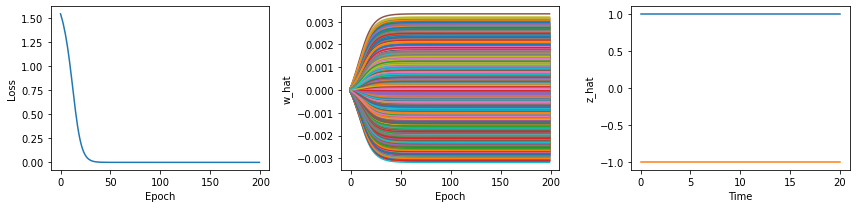

In [4]:
lr = 0.0001
nepoch = 200

w_T_hat = (0.*torch.ones((D, N), device=device)).detach()
w_T_hat.requires_grad = True

w_T_hat_flats = np.nan*np.ones((nepoch, D*N))

losses = []

for epoch in range(nepoch):

    # compute first terms (dE/dx_t) using autograd
    ## forward pass
    ### first initial condition
    x_hats_0 = [x_0s[0].clone()]
    z_hats_0 = [get_z(x_hats_0[0])]

    for t in range(1, T+1):
        x_hat_0 = advance(x_hats_0[t-1], z_hats_0[t-1], w_T_hat)
        x_hat_0.retain_grad()

        z_hat_0 = get_z(x_hat_0)

        x_hats_0.append(x_hat_0)
        z_hats_0.append(z_hat_0)

    x_hats_stack_0 = torch.stack(x_hats_0)
    z_hats_stack_0 = torch.stack(z_hats_0)

    loss_0 = loss_fn(z_hats_stack_0, targs[0])
    
    ### second initial condition
    x_hats_1 = [x_0s[1].clone()]
    z_hats_1 = [get_z(x_hats_1[0])]

    for t in range(1, T+1):
        x_hat_1 = advance(x_hats_1[t-1], z_hats_1[t-1], w_T_hat)
        x_hat_1.retain_grad()

        z_hat_1 = get_z(x_hat_1)

        x_hats_1.append(x_hat_1)
        z_hats_1.append(z_hat_1)

    x_hats_stack_1 = torch.stack(x_hats_1)
    z_hats_stack_1 = torch.stack(z_hats_1)

    loss_1 = loss_fn(z_hats_stack_1, targs[1])
    
    loss = loss_0 + loss_1
    
    ## backward pass
    loss.backward(retain_graph=True)

    ### classical factorization
    jac_x_hat_0_wrt_w_T_hats = []

    for t in range(1, T+1):
        jac = torch.autograd.functional.jacobian(advance, inputs=(x_hats_0[t-1], z_hats_0[t-1], w_T_hat))[2].reshape((D, D*N))

        jac_x_hat_0_wrt_w_T_hats.append(jac)

    summands_0 = [x_hat_0.grad@jac for x_hat_0, jac in zip(x_hats_0[1:], jac_x_hat_0_wrt_w_T_hats)]
    w_T_hat_grad_0 = torch.stack(summands_0).sum(dim=0).reshape((D, N))

    jac_x_hat_1_wrt_w_T_hats = []

    for t in range(1, T+1):
        jac = torch.autograd.functional.jacobian(advance, inputs=(x_hats_1[t-1], z_hats_1[t-1], w_T_hat))[2].reshape((D, D*N))

        jac_x_hat_1_wrt_w_T_hats.append(jac)

    summands_1 = [x_hat_1.grad@jac for x_hat_1, jac in zip(x_hats_1[1:], jac_x_hat_1_wrt_w_T_hats)]
    w_T_hat_grad_1 = torch.stack(summands_1).sum(dim=0).reshape((D, N))

    w_T_hat_grad = w_T_hat_grad_0 + w_T_hat_grad_1

    # weight update
    with torch.no_grad():
        w_T_hat -= lr*w_T_hat_grad
        if epoch == 0:
            print('x_hats_0', x_hats_stack_0.detach().cpu().numpy())
            print('x_hats_1', x_hats_stack_1.detach().cpu().numpy())
            print('w_T_hat.grad =', w_T_hat_grad.detach().cpu().numpy())
        w_T_hat.grad.zero_()

    losses.append(loss.item())
    w_T_hat_flats[epoch, :] = w_T_hat.detach().cpu().numpy().flatten()

fig, axs = plt.subplots(1, 3, figsize=(12, 3), tight_layout=True)
axs[0].plot(losses)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

axs[1].plot(w_T_hat_flats)
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('w_hat')

axs[2].plot(z_hats_stack_0.detach().cpu().numpy())
axs[2].plot(z_hats_stack_1.detach().cpu().numpy())
axs[2].set_xlabel('Time')
axs[2].set_ylabel('z_hat')

## The e-prop factorization

$$\frac{dE}{dW_{ij}} = \sum_t \frac{dE}{d\hat{z}_i^t} \left[ \frac{\partial \hat{z}_i^t}{\partial W_{ij}} \right]_{local} = \sum_t \frac{dE}{d\hat{z}_i^t} e_{ij}^t$$

where

$$
e_{ij}^t = \left[ \frac{\partial \hat{z}_i^t}{\partial W_{ij}} \right]_{local} = \frac{\partial \hat{z}_i^t}{\partial \hat{x}_i^t} \sum_{t' \leq t}\frac{\partial \hat{x}_i^t}{\partial \hat{x}_i^{t-1}} \dots \frac{\partial \hat{x}_i^{t'+1}}{\partial \hat{x}_i^{t'}}
\frac{\partial \hat{x}_i^{t'}}{\partial W_{ij}}
$$


Or, in vector format (note that $\frac{dE}{d\mathbf{w}_i}$, $\mathbf{e}_i^t$, and $\boldsymbol{\epsilon}_i^t$ are all row vectors):

$$\frac{dE}{d\mathbf{w}_i} = \sum_t \frac{dE}{d\hat{z}_i^t} \left[ \frac{\partial \hat{z}_i^t}{\partial \mathbf{w}_i} \right]_{local} = \sum_t \frac{dE}{d\hat{z}_i^t} \mathbf{e}_i^t = \sum_t L_i^t \mathbf{e}_i^t$$

where

$$
\mathbf{e}_i^t = \left[ \frac{\partial \hat{z}_i^t}{\partial \mathbf{w}_i} \right]_{local} = \frac{\partial \hat{z}_i^t}{\partial \hat{x}_i^t} \sum_{t' \leq t}\frac{\partial \hat{x}_i^t}{\partial \hat{x}_i^{t-1}} \dots \frac{\partial \hat{x}_i^{t'+1}}{\partial \hat{x}_i^{t'}}
\frac{\partial \hat{x}_i^{t'}}{\partial \mathbf{w}_i}
= \frac{\partial \hat{z}_i^t}{\partial \hat{x}_i^t} \boldsymbol{\epsilon}_i^t
$$

with

$$
\boldsymbol{\epsilon}_i^t \equiv \sum_{t' \leq t}\frac{\partial \hat{x}_i^t}{\partial \hat{x}_i^{t-1}} \dots \frac{\partial \hat{x}_i^{t'+1}}{\partial \hat{x}_i^{t'}}
\frac{\partial \hat{x}_i^{t'}}{\partial \mathbf{w}_i}
$$

which can also be computed recursively:

$$
\boldsymbol{\epsilon}_i^1 = \frac{\partial \hat{x}_i^1}{\partial \mathbf{w}_i} \quad \quad \quad
\boldsymbol{\epsilon}_i^t = \frac{\partial \hat{x}_i^t}{\partial \hat{x}_i^{t-1}} \boldsymbol{\epsilon}_i^{t-1} + \frac{\partial \hat{x}_i^t}{\partial \mathbf{w}_i}
$$

## E-prop

We first study the ideal case (above), in which the factorization should reproduce the full BPTT gradient exactly. Set use_approx to True to see
approx e-prop (where learning signal is replaced with partial derivative).

Ls_0 = [None, tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([-1.7568])]
Ls_approx_0 = [tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([-1.7568])]
Ls_1 = [None, tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([-1.7568])]
Ls_approx_1 = [tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), ten

Text(0, 0.5, 'z_hat')

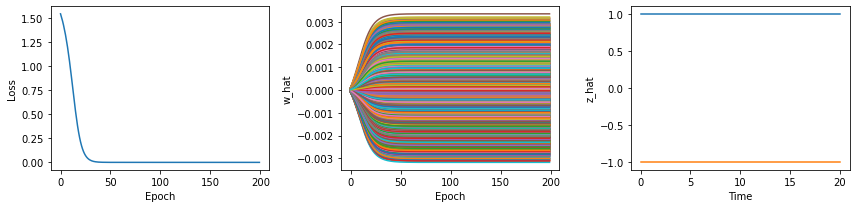

In [5]:
w_T_hat = (0.*torch.ones((D, N), device=device)).detach()
w_T_hat.requires_grad = True

w_T_hat_flats = np.nan*np.ones((nepoch, D*N))
use_approx = False
# use_approx = True

losses = []

for epoch in range(nepoch):
    # compute first terms (dE/dx_t) using autograd
    x_hats_0 = [x_0s[0].clone()]
    z_hats_0 = [get_z(x_hats_0[0])]

    for t in range(1, T+1):
        x_hat_0 = advance(x_hats_0[t-1], z_hats_0[t-1], w_T_hat)
        x_hat_0.retain_grad()

        z_hat_0 = get_z(x_hat_0)
        z_hat_0.retain_grad()

        x_hats_0.append(x_hat_0)
        z_hats_0.append(z_hat_0)

    x_hats_stack_0 = torch.stack(x_hats_0)
    z_hats_stack_0 = torch.stack(z_hats_0)
    z_hats_stack_0.retain_grad()

    loss_0 = loss_fn(z_hats_stack_0, targs[0])

    ### second initial condition
    x_hats_1 = [x_0s[1].clone()]
    z_hats_1 = [get_z(x_hats_1[0])]

    for t in range(1, T+1):
        x_hat_1 = advance(x_hats_1[t-1], z_hats_1[t-1], w_T_hat)
        x_hat_1.retain_grad()

        z_hat_1 = get_z(x_hat_1)
        z_hat_1.retain_grad()

        x_hats_1.append(x_hat_1)
        z_hats_1.append(z_hat_1)

    x_hats_stack_1 = torch.stack(x_hats_1)
    z_hats_stack_1 = torch.stack(z_hats_1)
    z_hats_stack_1.retain_grad()

    loss_1 = loss_fn(z_hats_stack_1, targs[1])

    loss = loss_0 + loss_1
    loss.backward(retain_graph=True)

    # get learning signals (x_hats grad)
    Ls_0 = [z_hat_0.grad for z_hat_0 in z_hats_0]
    Ls_1 = [z_hat_1.grad for z_hat_1 in z_hats_1]
    Ls_approx_0 = [grad for grad in z_hats_stack_0.grad]
    Ls_approx_1 = [grad for grad in z_hats_stack_1.grad]

    if epoch%50 == 0:
        print('Ls_0 =', Ls_0)
        print('Ls_approx_0 =', Ls_approx_0)
        print('Ls_1 =', Ls_0)
        print('Ls_approx_1 =', Ls_approx_0)

    w_T_hat.grad.zero_()

    ## get eligibility vectors
    evs_0 = torch.zeros((T+1, D, N), device=device)  # each row is an e-vector

    for t in range(1, T+1):
        partial_x_hat_0, partial_z_hat_0, partial_w_T_hat_0 = torch.autograd.functional.jacobian(advance, inputs=(x_hats_0[t-1], z_hats_0[t-1], w_T_hat))
        # loop over neurons
        for i in range(D):
            evs_0[t, i, :] = partial_x_hat_0[i, i]*evs_0[t-1, i, :] + partial_w_T_hat_0[i][i, :]

    # convert to eligibility traces
    ets_0 = 1*evs_0  # special case for identity activation function

    # compute gradient
    e_prop_grad_0 = torch.zeros((D, N), device=device)
    e_prop_grad_approx_0 = torch.zeros((D, N), device=device)
    for t in range(1, T+1):
        e_prop_grad_0 += Ls_0[t][:, None]*ets_0[t, i, :]
        e_prop_grad_approx_0 += Ls_approx_0[t][:, None]*ets_0[t, i, :]

    evs_1 = torch.zeros((T+1, D, N), device=device)  # each row is an e-vector

    for t in range(1, T+1):
        partial_x_hat_1, partial_z_hat_1, partial_w_T_hat_1 = torch.autograd.functional.jacobian(advance, inputs=(x_hats_1[t-1], z_hats_1[t-1], w_T_hat))
        # loop over neurons
        for i in range(D):
            evs_1[t, i, :] = partial_x_hat_1[i, i]*evs_1[t-1, i, :] + partial_w_T_hat_1[i][i, :]

    # convert to eligibility traces
    ets_1 = 1*evs_1  # special case for identity activation function

    # compute gradient
    e_prop_grad_1 = torch.zeros((D, N), device=device)
    e_prop_grad_approx_1 = torch.zeros((D, N), device=device)
    for t in range(1, T+1):
        e_prop_grad_1 += Ls_1[t][:, None]*ets_1[t, i, :]
        e_prop_grad_approx_1 += Ls_approx_1[t][:, None]*ets_1[t, i, :]

    e_prop_grad = e_prop_grad_0 + e_prop_grad_1
    e_prop_grad_approx = e_prop_grad_approx_0 + e_prop_grad_approx_1

    with torch.no_grad():
        if use_approx:
            w_T_hat -= lr*e_prop_grad_approx
        else:
            w_T_hat -= lr*e_prop_grad

    losses.append(loss.item())
    w_T_hat_flats[epoch, :] = w_T_hat.detach().cpu().numpy().flatten()

fig, axs = plt.subplots(1, 3, figsize=(12, 3), tight_layout=True)
axs[0].plot(losses)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

axs[1].plot(w_T_hat_flats)
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('w_hat')

axs[2].plot(z_hats_stack_0.detach().cpu().numpy())
axs[2].plot(z_hats_stack_1.detach().cpu().numpy())
axs[2].set_xlabel('Time')
axs[2].set_ylabel('z_hat')